In [2]:
from expDJ.nb_4Dj import *

In [3]:
# Get MNIST data

x_train,y_train,x_valid,y_valid = get_data()
type(x_train)

torch.Tensor

In [4]:
#export
# Function to normalize the trainig data and validation data
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
# Normalize the x training and vaiation data
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [6]:
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
# Make the datasets
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid) 
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

# Make samplers

train_Smp, valid_Smp = SamplerDJ(train_ds, bs, shuffle=True), SamplerDJ(valid_ds, bs, shuffle=True)

# Make data loaders

train_dl, valid_dl = DataLoaderDJ(train_ds, train_Smp, bs), DataLoaderDJ(valid_ds, valid_Smp, bs)

# Make databunch
db = DataBunchDJ(train_dl, valid_dl, c = c)
db

In [8]:
#export
# Reform MNIST data
class LambdaDJ(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)
    
def flatten(x):      return x.view(x.shape[0], -1)
def resize_MNIST(x): return x.view(-1, 1, 28, 28)
        
    


In [9]:
x_train.shape,resize_MNIST(x_train).shape

(torch.Size([50000, 784]), torch.Size([50000, 1, 28, 28]))

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        LambdaDJ(resize_MNIST),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        LambdaDJ(flatten),
        nn.Linear(32,data.c)
    )

nn.Conv2d

torch.nn.modules.conv.Conv2d

In [119]:
nn.Module
# Model
model = get_cnn_model(db)

In [116]:
class earlyStop(Callback):
    _order = 1
    def __init__(self, stopIt = 3):
        self.stopIt = stopIt
        
    #def after_batch(self):
        #print(self.n_iter)
     #   if self.n_iter > 10:
       #     self.run.stop = True
      #      return True
        #print(self.stop) 
            
        #pass
        
    def after_epoch(self):
        print(self.run.epoch)
        if self.run.epoch == self.stopIt:
            self.run.early_stop.stopIt
            #self.stop = True
            return True

        
class printPreds(Callback):
    _order = 0
    def after_batch(self):
        print(run.pred[15])
        print(run.yb[15])
        
class accuracyCheckCb(Callback):
    _order = 1
    
    def __init__(self, m):
        self.m = m
        
    def after_batch(self):
        print(self.m(run.pred, run.yb))

# Callbacks
cbfs = [Recorder, partial(AvgStatsCallback,accuracy), partial(earlyStop, 3)]

In [120]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = LearnerDJ(db, model, opt, loss_func)
run = RunnerDJ(cb_funcs=cbfs)



recorder
avg_stats
early_stop


In [118]:

%time run.fit(5, learn)
#run.iters

Epoch: 0
train: [2.15603390625, tensor(0.2403)]
valid: [1.59974716796875, tensor(0.4651)]
0
Epoch: 1
train: [0.6307101953125, tensor(0.8041)]
valid: [0.596889404296875, tensor(0.8193)]
1
Epoch: 2
train: [0.23403173828125, tensor(0.9269)]
valid: [0.1756041259765625, tensor(0.9470)]
2
Epoch: 3
train: [0.159969462890625, tensor(0.9510)]
valid: [0.261133056640625, tensor(0.9123)]
3
CPU times: user 43.5 s, sys: 420 ms, total: 44 s
Wall time: 17.4 s


In [121]:
# Cuda
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [135]:
model = get_cnn_model(db)
opt = optim.SGD(model.parameters(), lr=0.4)
learn = LearnerDJ(db, model, opt, loss_func)
cbfs = [Recorder, partial(AvgStatsCallback,accuracy),CudaCallback]
run = RunnerDJ(cb_funcs=cbfs)

%time run.fit(5, learn)

recorder
avg_stats
cuda
Epoch: 0
train: [1.891744375, tensor(0.3218, device='cuda:0')]
valid: [1.15431328125, tensor(0.6579, device='cuda:0')]
Epoch: 1
train: [0.43232734375, tensor(0.8658, device='cuda:0')]
valid: [0.183430224609375, tensor(0.9477, device='cuda:0')]
Epoch: 2
train: [0.17433431640625, tensor(0.9475, device='cuda:0')]
valid: [0.1339638916015625, tensor(0.9606, device='cuda:0')]
Epoch: 3
train: [0.138340048828125, tensor(0.9584, device='cuda:0')]
valid: [0.10474097900390625, tensor(0.9691, device='cuda:0')]
Epoch: 4
train: [0.1018027734375, tensor(0.9681, device='cuda:0')]
valid: [0.1017208740234375, tensor(0.9696, device='cuda:0')]
CPU times: user 14 s, sys: 2.39 s, total: 16.4 s
Wall time: 16.4 s


tensor([-0.0339,  0.1177, -0.0304,  0.0103, -0.0216, -0.0874, -0.0294,  0.0225,
        -0.0539, -0.0170], grad_fn=<SelectBackward>)

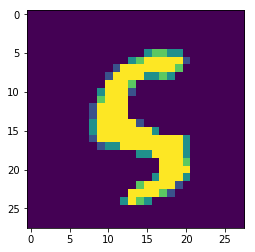

In [62]:
plt.imshow(x_valid[10].view(28,28))
pred = model.cpu()(x_valid[10:12]),y_valid,
x_valid[10].shape, 
#loss_func(pred[0], pred[1])
#loss_func(pred[0], pred[1][10:12])
#pred[1][10:11]
pred[0][1]

## Hooks

In [140]:
act_means = []
act_stds = []

def append_stats(mod, inp, outp):
    act_means.append(outp.data.mean())
    act_stds.append(outp.data.std())

model = get_cnn_model(db)
opt = optim.SGD(model.parameters(), lr=0.4)
learn = LearnerDJ(db, model, opt, loss_func)
cbfs = [Recorder, partial(AvgStatsCallback,accuracy),CudaCallback]
run = RunnerDJ(cb_funcs=cbfs)

model[3].register_forward_hook(append_stats)
%time run.fit(5, learn)   



recorder
avg_stats
cuda
Epoch: 0
train: [1.93618375, tensor(0.3463, device='cuda:0')]
valid: [1.22147509765625, tensor(0.5735, device='cuda:0')]
Epoch: 1
train: [0.38976859375, tensor(0.8798, device='cuda:0')]
valid: [0.2823456298828125, tensor(0.9133, device='cuda:0')]
Epoch: 2
train: [0.18047119140625, tensor(0.9455, device='cuda:0')]
valid: [0.137530224609375, tensor(0.9612, device='cuda:0')]
Epoch: 3
train: [0.147274873046875, tensor(0.9571, device='cuda:0')]
valid: [0.10690611572265625, tensor(0.9700, device='cuda:0')]
Epoch: 4
train: [0.109188212890625, tensor(0.9674, device='cuda:0')]
valid: [0.10209159545898437, tensor(0.9712, device='cuda:0')]
CPU times: user 15.2 s, sys: 2.43 s, total: 17.6 s
Wall time: 17.7 s


Epoch: 0
train: [2.30591640625, tensor(0.0994, device='cuda:0')]
valid: [2.3070548828125, tensor(0.0990, device='cuda:0')]
Epoch: 1
train: [2.3059165625, tensor(0.0994, device='cuda:0')]
valid: [2.3070548828125, tensor(0.0990, device='cuda:0')]
Epoch: 2
train: [2.30591671875, tensor(0.0994, device='cuda:0')]
valid: [2.3070548828125, tensor(0.0990, device='cuda:0')]
CPU times: user 8.31 s, sys: 1.48 s, total: 9.79 s
Wall time: 9.79 s


([<matplotlib.lines.Line2D at 0x7ff145a87550>],
 [<matplotlib.lines.Line2D at 0x7ff145a87978>])

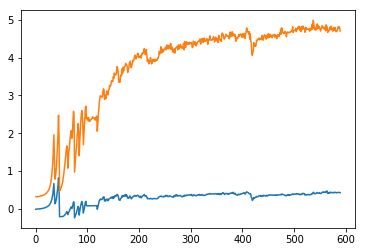

In [141]:
plt.plot(act_means),plt.plot(act_stds)